In [1]:
import tensorflow as tf 
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt 

Loading the dataset into batches (tensorflow dataset )

In [11]:
dataset = tf.keras.preprocessing.image_dataset_from_directory("PlantVillage",shuffle=True,image_size=(256,256),batch_size=32)

Found 2152 files belonging to 3 classes.


In [12]:
class_names = dataset.class_names

In [13]:
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [14]:
len(dataset)

68

In [70]:
#The dataset data is stored as tensors , to convert it into numpy do .numpy()
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    print(image_batch[0].shape)
    image_shape = image_batch[0].shape
    print(image_shape)
# 3 = rgb channel

(32, 256, 256, 3)
[0 1 0 1 1 1 0 1 0 2 1 0 1 0 0 0 1 2 1 0 0 1 1 1 0 0 1 1 1 0 2 0]
(256, 256, 3)
(256, 256, 3)


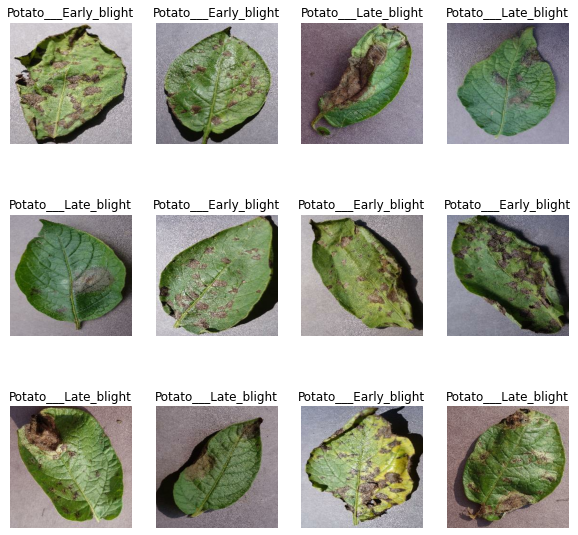

In [38]:
plt.figure(figsize =(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [42]:
#we have 2152 images in total in our computer folders
#32*68 = 2176
train_size = 0.8
validation_size = 0.1
test_size = 0.1
len(dataset)*train_size

54.400000000000006

In [43]:
#take first 54 shuffled batches in the train dataset
train_ds = dataset.take(54)
len(train_ds)

54

In [44]:
test_val_ds = dataset.skip(54)
len(test_val_ds)

14

In [45]:
val_ds = test_val_ds.take(6)
len(val_ds)

6

In [47]:
test_ds = test_val_ds.skip(6)
len(test_ds)

8

In [58]:
def get_train_val_test_ds(ds,train_size_=0.8,val_size_=0.1,test_size_=0.1,shuffle=True,shuffle_size = 10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed = 12) #seed is just an argument for getting same type of anwers everytime
    train_size = int(train_size_*ds_size)
    val_size = int(val_size_ * ds_size)
    test_size = int(test_size_ * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [59]:
train_ds,val_ds,test_ds = get_train_val_test_ds(dataset)

In [60]:
len(train_ds)

54

In [61]:
len(val_ds)

6

In [62]:
len(test_ds)

8

Optimising my dataset so that it runs faster

In [63]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size =tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size =tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size =tf.data.AUTOTUNE)

In [64]:
resize_and_rescale_layer = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(256,256),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [65]:
data_augmentation_layer = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2),  
])

In [74]:
batch_size = 32
image_size = 256
channels = 3
input_shape = (batch_size ,image_size,image_size,channels)
n_classes = 3
model = models.Sequential([
    resize_and_rescale_layer,
    data_augmentation_layer,
    layers.Conv2D(32,kernel_size = (3,3),activation='relu',input_shape = input_shape),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64,kernel_size = (3,3),activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64,kernel_size = (3,3),activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64,kernel_size = (3,3),activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64,kernel_size = (3,3),activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64,kernel_size = (3,3),activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(64,activation = 'relu'),
    layers.Dense(n_classes,activation='softmax'),
    
])
model.build(input_shape=input_shape)

In [75]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_7 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [77]:
model.compile(
    optimizer= 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics =['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    epochs = 50,
    batch_size = 32,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/50
54/54 [==============================] - 124s 2s/step - loss: 0.5379 - accuracy: 0.7743 - val_loss: 0.3581 - val_accuracy: 0.8490
Epoch 2/50
54/54 [==============================] - 108s 2s/step - loss: 0.3736 - accuracy: 0.8490 - val_loss: 0.3260 - val_accuracy: 0.8542
Epoch 3/50
54/54 [==============================] - 110s 2s/step - loss: 0.3413 - accuracy: 0.8681 - val_loss: 0.2873 - val_accuracy: 0.8854
Epoch 4/50
54/54 [==============================] - 106s 2s/step - loss: 0.2756 - accuracy: 0.8953 - val_loss: 0.2399 - val_accuracy: 0.9167
Epoch 5/50
54/54 [==============================] - 106s 2s/step - loss: 0.2681 - accuracy: 0.8866 - val_loss: 0.2278 - val_accuracy: 0.9271
Epoch 6/50
54/54 [==============================] - 112s 2s/step - loss: 0.2113 - accuracy: 0.9230 - val_loss: 0.2087 - val_accuracy: 0.9323
Epoch 7/50
54/54 [==============================] - 104s 2s/step - loss: 0.2120 - accuracy: 0.9219 - val_loss: 0.1397 - val_accuracy: 0.9479
Epoch 8/50
54